This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce 

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_em as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_em as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda
torch.cuda.set_device(0)

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=128, help='number of embedding dimension [default: 128]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-7.8810)
args.L2 = np.exp(-5.8401)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
#args.seq_file = 'Data/h143.visits'
#args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
def data_load_split_VT(folder = 'data2/cerner/hospital_data/', hosp_list=[143,104,118], test_r=0.2 , valid_r=0.1):

   merged_set=[]
   for h in hosp_list:
       seqFile= folder+'h'+str(h)+'.visits'
       labelFile= folder+'h'+str(h)+'.labels'
       set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
       set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')
       #merged_set_h = [[set_y[i],set_x[i]] for i in range(len(set_x))] # merge the two lists
       merged_set_f = [[set_y[i],set_x[i][:-1]] for i in range(len(set_y))] # added [:-1] to exclude last visit
       merged_set_h =[x for x in merged_set_f if len(x[1])>0]

       merged_set.extend(merged_set_h)

   #print (set_y[1],set_x[1][:-1], len(set_x[1][:-1]))

   # set random seed
   random.seed( 3 )

   dataSize = len(merged_set)
   nTest = int(test_r * dataSize)
   nValid = int(valid_r * dataSize)

   random.shuffle(merged_set)

   test_set = merged_set[:nTest]
   valid_set = merged_set[nTest:nTest+nValid]
   train_set = merged_set[nTest+nValid:]

   return train_set, valid_set, test_set

In [6]:
train1 , valid1, test1 = data_load_split_VT()
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print (len(train1),len(valid1),len(test1))

80241 11463 22926


In [7]:
# load and prepare data
#set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
#set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
#model_x = set_x     

#merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
#train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
#test_sh_L =[x for x in test1 if len(x[1])< 5]
#test_l_L = [x for x in test1 if x not in test_sh_L]
#print(test_sh_L[0])
#print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[360, 379, 62, 63], [4902, 5117, 57, 252, 449, 379, 62, 63]]]
model is LR
------------------------------------------------------------------------------------------------------------------------

After flatten:
[0, [375, 83, 84, 63, 1250, 83, 84, 63, 195, 1250, 83, 84, 63, 1536, 83, 84, 63, 622, 68, 1632, 3059, 83, 84, 63, 1429, 622, 1756, 1306, 703, 354, 83, 84, 63, 8827, 559, 475, 83, 84, 63, 872, 83, 84, 63, 1250, 83, 84, 63]]
[0, [12, 195, 134, 16, 196, 186, 656, 198, 187, 188, 74, 550, 31, 8, 102, 35, 37, 540, 572, 356, 228, 879, 196, 260, 10, 6, 8, 188, 74, 6, 8]]
[0, [88, 16, 157, 158, 198, 91, 22, 165, 166, 96, 135, 167, 901, 1970, 31, 137, 139, 226, 102, 172, 958, 356, 175, 1102, 266, 880, 88, 157, 139, 156, 88, 16, 157, 198, 161, 22, 23, 165, 1259, 260, 223, 166, 167, 136, 29, 855, 1910, 31, 139, 101, 171, 172, 49, 175, 880, 88, 4884, 31, 12, 88, 134, 16, 2, 1270, 158, 23, 165, 1259, 223, 166, 1970, 31, 226, 101, 1

Parameter containing:
 2.2952e-01 -8.2319e-01
-1.0364e-01  1.3544e-01
 1.7713e+00  1.3312e+00
           ⋮            
 2.2347e-02  1.4358e+00
 1.4508e-01  4.1741e-01
 3.5738e-01 -1.1669e+00
[torch.FloatTensor of size 20000x2]

15815
      emb_0     emb_1                           types
0  0.229524 -0.823188                            Code
1 -0.103641  0.135441  b'M_ACETAMINOPHEN-HYDROCODONE'
2  1.771297  1.331249         b'M_BACITRACIN TOPICAL'
3 -0.081637  1.863408    b'M_BUPIVACAINE-EPINEPHRINE'
4  0.963011 -0.711536                  b'M_CEFAZOLIN'


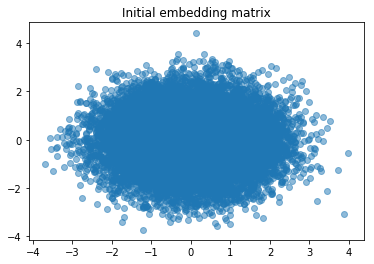

In [8]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [9]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep = []
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [10]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.4375997426477437


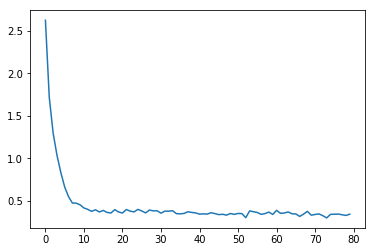

Epoch  0 Summary:  Training_auc : 0.7418957646678722  , Validation_auc :  0.7365464718970081  ,Test_auc :  0.7375016307890618 Test_auc on short visits: 0.7174006521987362 Test_auc on long visits: 0.7596328442984039  Avg Loss:  0.4375997426477437 Train Time (2m 21s) Eval Time (1m 44s)


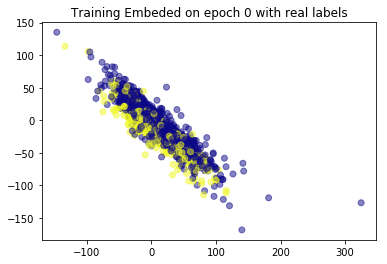

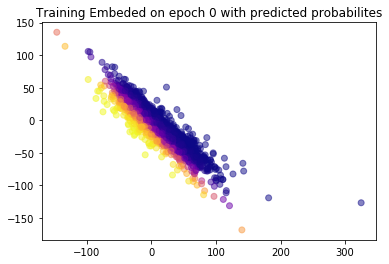


 Current running on: Epoch  1 Training loss:  Average loss 0.3380592065160322


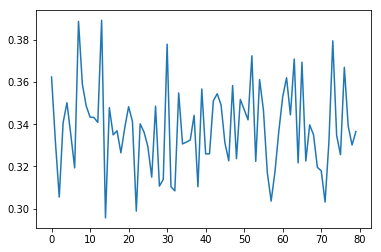

Epoch  1 Summary:  Training_auc : 0.7497349334710278  , Validation_auc :  0.7414624904918977  ,Test_auc :  0.7441191095935897 Test_auc on short visits: 0.7201428021050312 Test_auc on long visits: 0.7725470071978711  Avg Loss:  0.3380592065160322 Train Time (2m 23s) Eval Time (2m 55s)


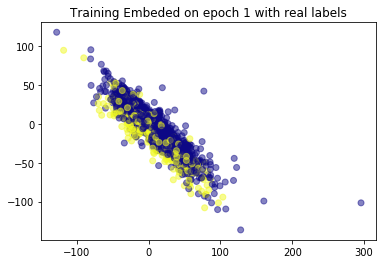

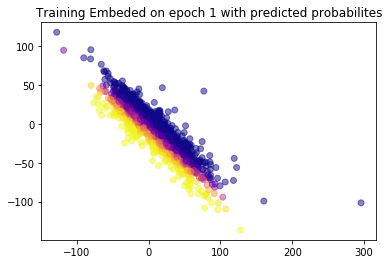


 Current running on: Epoch  2 Training loss:  Average loss 0.336501061538392


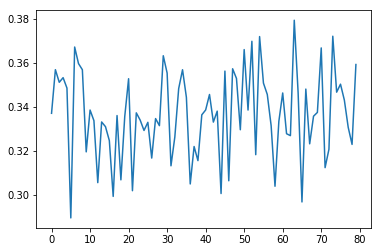

Epoch  2 Summary:  Training_auc : 0.7456757458059016  , Validation_auc :  0.7399963001273925  ,Test_auc :  0.7454530435088631 Test_auc on short visits: 0.7228690247466287 Test_auc on long visits: 0.7668107517546561  Avg Loss:  0.336501061538392 Train Time (2m 8s) Eval Time (1m 30s)


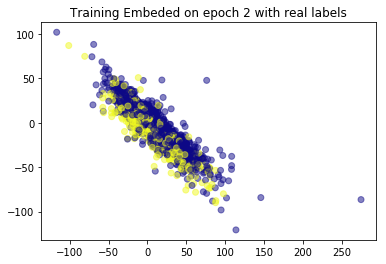

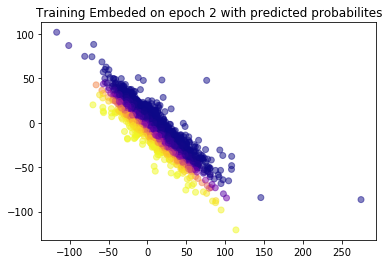


 Current running on: Epoch  3 Training loss:  Average loss 0.3366504899695567


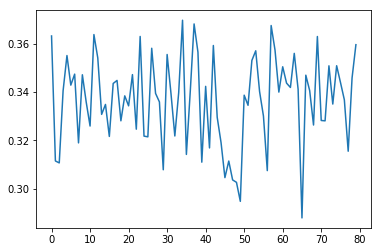

Epoch  3 Summary:  Training_auc : 0.7509679426389126  , Validation_auc :  0.7486543584713181  ,Test_auc :  0.7479188849201857 Test_auc on short visits: 0.7226133833969853 Test_auc on long visits: 0.7727055927957559  Avg Loss:  0.3366504899695567 Train Time (1m 46s) Eval Time (1m 18s)


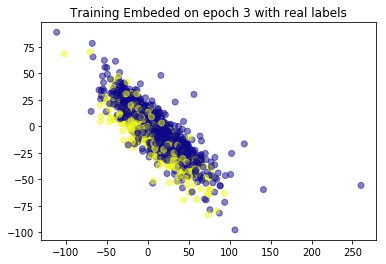

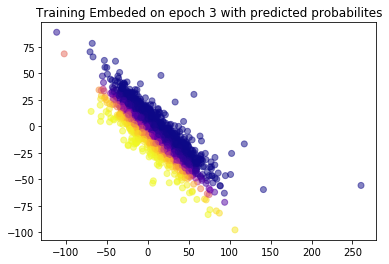


 Current running on: Epoch  4 Training loss:  Average loss 0.3357610805792487


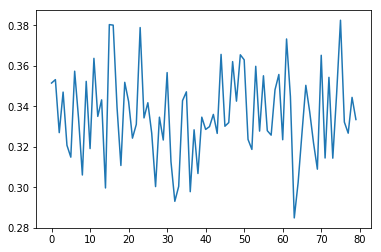

Epoch  4 Summary:  Training_auc : 0.7516669094639561  , Validation_auc :  0.7493186246169135  ,Test_auc :  0.7458734318472268 Test_auc on short visits: 0.7212622612809315 Test_auc on long visits: 0.770332778561553  Avg Loss:  0.3357610805792487 Train Time (1m 45s) Eval Time (1m 18s)


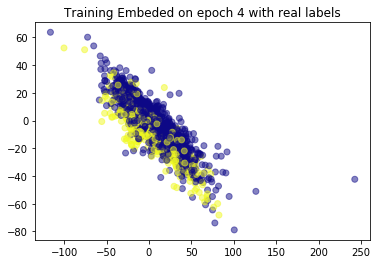

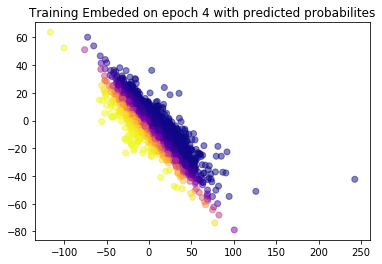


 Current running on: Epoch  5 Training loss:  Average loss 0.335730288277905


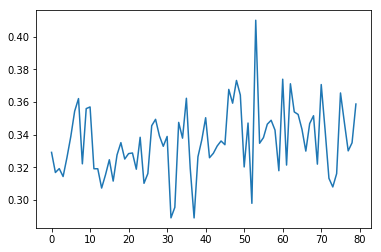

Epoch  5 Summary:  Training_auc : 0.7537876584261929  , Validation_auc :  0.7493652116448322  ,Test_auc :  0.7492314492406413 Test_auc on short visits: 0.7260708250106083 Test_auc on long visits: 0.7731264202830787  Avg Loss:  0.335730288277905 Train Time (1m 55s) Eval Time (1m 20s)


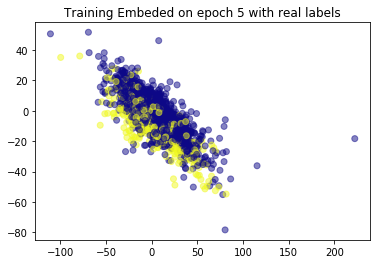

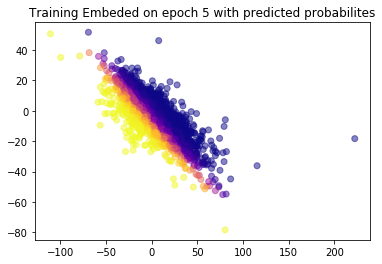


 Current running on: Epoch  6 Training loss:  Average loss 0.3365252605705804


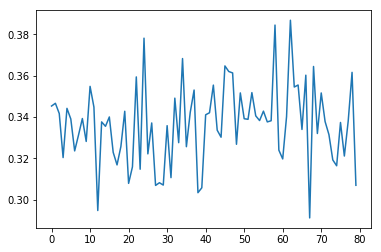

Epoch  6 Summary:  Training_auc : 0.7454146322037959  , Validation_auc :  0.7328523380129474  ,Test_auc :  0.7450137335998943 Test_auc on short visits: 0.7170027156161334 Test_auc on long visits: 0.7715366490890302  Avg Loss:  0.3365252605705804 Train Time (2m 2s) Eval Time (2m 40s)


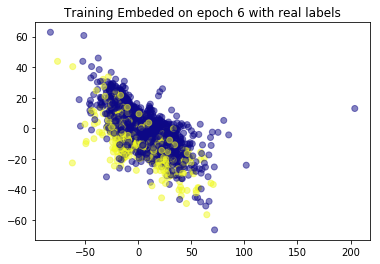

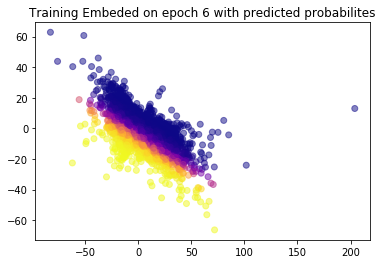


 Current running on: Epoch  7 Training loss:  Average loss 0.3356549850380102


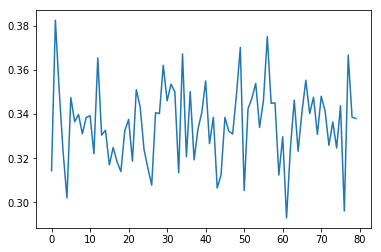

Epoch  7 Summary:  Training_auc : 0.7525196284270049  , Validation_auc :  0.7429480713255595  ,Test_auc :  0.7460975733122511 Test_auc on short visits: 0.7249843055184017 Test_auc on long visits: 0.7687640564947721  Avg Loss:  0.3356549850380102 Train Time (1m 53s) Eval Time (1m 20s)


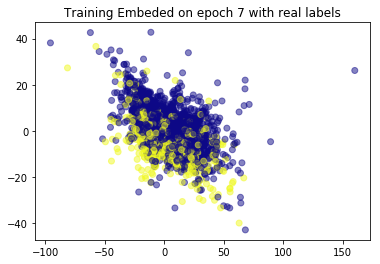

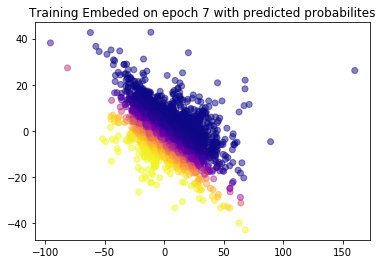


 Current running on: Epoch  8 Training loss:  Average loss 0.33486330228708167


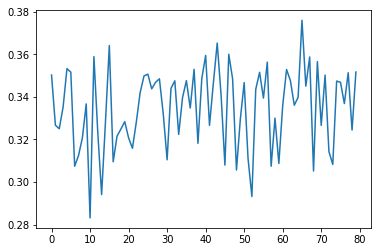

Epoch  8 Summary:  Training_auc : 0.7451265952049684  , Validation_auc :  0.7374560060908887  ,Test_auc :  0.7443429013408694 Test_auc on short visits: 0.7234097466318736 Test_auc on long visits: 0.7654646930157288  Avg Loss:  0.33486330228708167 Train Time (1m 48s) Eval Time (1m 17s)


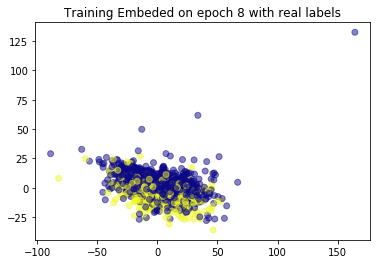

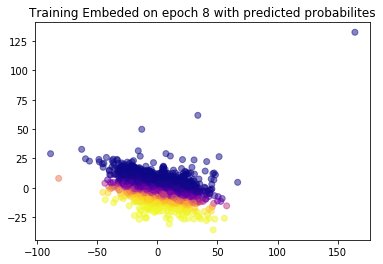


 Current running on: Epoch  9 Training loss:  Average loss 0.33531116740098305


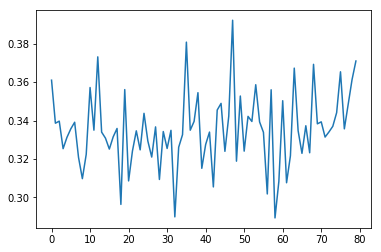

Epoch  9 Summary:  Training_auc : 0.7503419621998766  , Validation_auc :  0.7451511708065081  ,Test_auc :  0.7490960624579694 Test_auc on short visits: 0.7292599534727844 Test_auc on long visits: 0.7710009236031423  Avg Loss:  0.33531116740098305 Train Time (2m 37s) Eval Time (1m 57s)


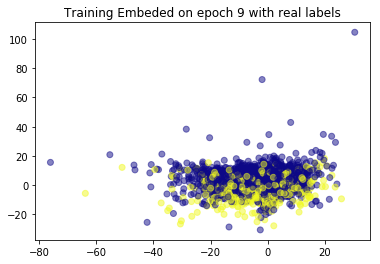

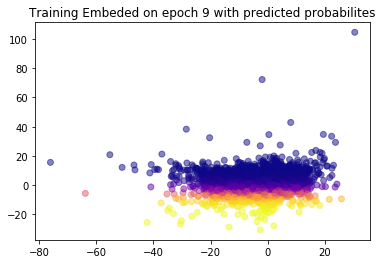


 Current running on: Epoch  10 Training loss:  Average loss 0.33496240982203523


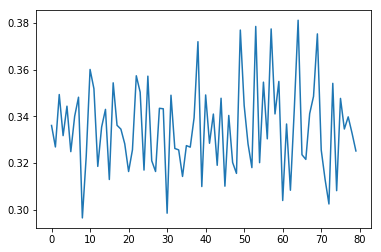

Epoch  10 Summary:  Training_auc : 0.7576949683389199  , Validation_auc :  0.7538754918014673  ,Test_auc :  0.7481503980671431 Test_auc on short visits: 0.7233321405970714 Test_auc on long visits: 0.7730174920185819  Avg Loss:  0.33496240982203523 Train Time (1m 59s) Eval Time (1m 19s)


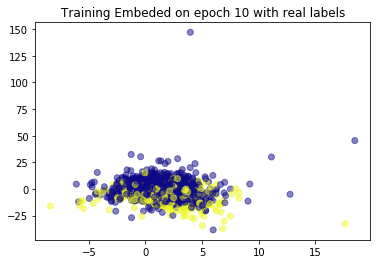

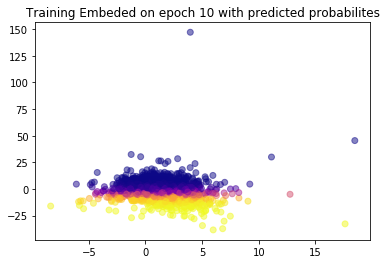


 Current running on: Epoch  11 Training loss:  Average loss 0.33452334912277476


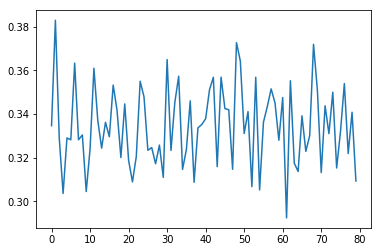

Epoch  11 Summary:  Training_auc : 0.7533320658521874  , Validation_auc :  0.7508617709058841  ,Test_auc :  0.7475072579316353 Test_auc on short visits: 0.7242084201952675 Test_auc on long visits: 0.771750008935219  Avg Loss:  0.33452334912277476 Train Time (1m 55s) Eval Time (1m 18s)


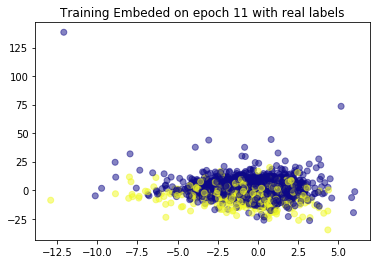

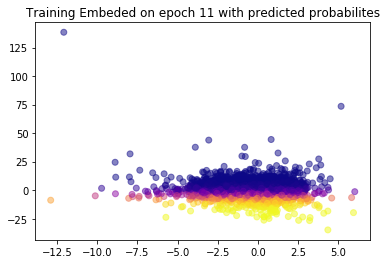


 Current running on: Epoch  12 Training loss:  Average loss 0.3342180384905054


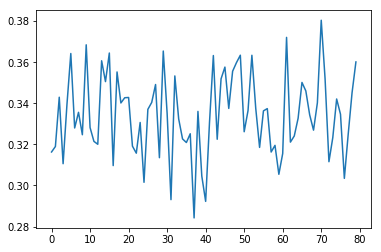

Epoch  12 Summary:  Training_auc : 0.7628870157282166  , Validation_auc :  0.7573124168152436  ,Test_auc :  0.7545958801629935 Test_auc on short visits: 0.7286774356445742 Test_auc on long visits: 0.7823552027434106  Avg Loss:  0.3342180384905054 Train Time (1m 54s) Eval Time (1m 18s)


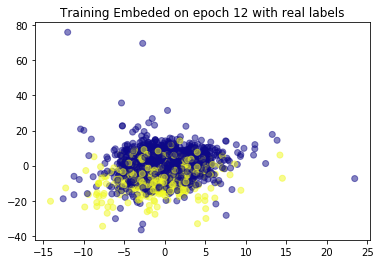

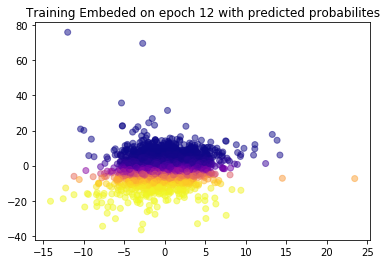


 Current running on: Epoch  13 Training loss:  Average loss 0.33461238839085367


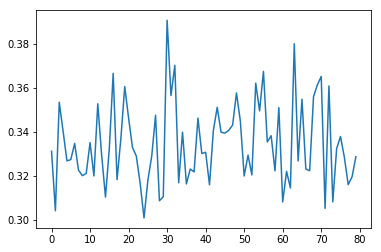

Epoch  13 Summary:  Training_auc : 0.7555430094509215  , Validation_auc :  0.7497339513570122  ,Test_auc :  0.7486538443698608 Test_auc on short visits: 0.7345200814103757 Test_auc on long visits: 0.7678206446894138  Avg Loss:  0.33461238839085367 Train Time (1m 58s) Eval Time (1m 17s)


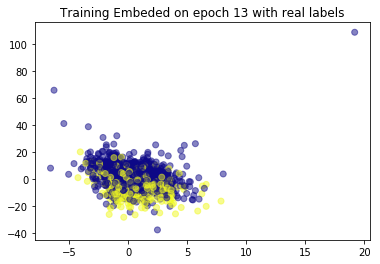

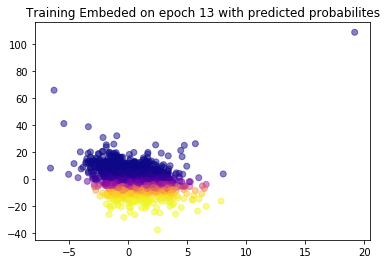


 Current running on: Epoch  14 Training loss:  Average loss 0.33430875746580907


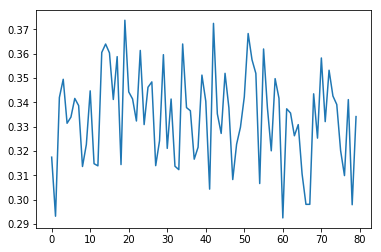

Epoch  14 Summary:  Training_auc : 0.7554307844961499  , Validation_auc :  0.7460390332995663  ,Test_auc :  0.7472682074469705 Test_auc on short visits: 0.7221560783727838 Test_auc on long visits: 0.7705595896916492  Avg Loss:  0.33430875746580907 Train Time (2m 15s) Eval Time (2m 15s)


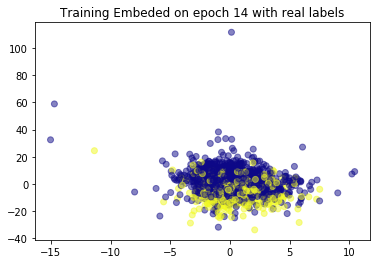

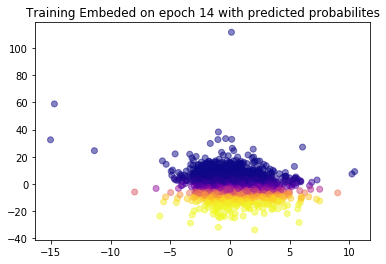


 Current running on: Epoch  15 Training loss:  Average loss 0.3346824083918748


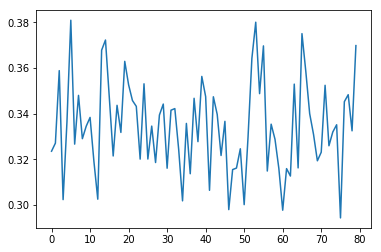

Epoch  15 Summary:  Training_auc : 0.7488638404991169  , Validation_auc :  0.7451750524505063  ,Test_auc :  0.7462707204082465 Test_auc on short visits: 0.7290766324063619 Test_auc on long visits: 0.7671788595125425  Avg Loss:  0.3346824083918748 Train Time (2m 17s) Eval Time (1m 37s)


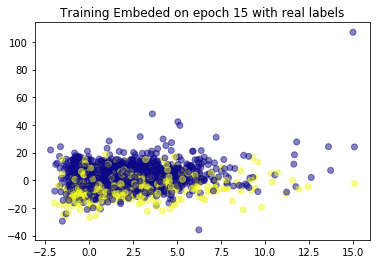

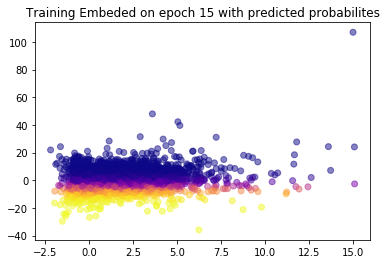


 Current running on: Epoch  16 Training loss:  Average loss 0.33443805704995705


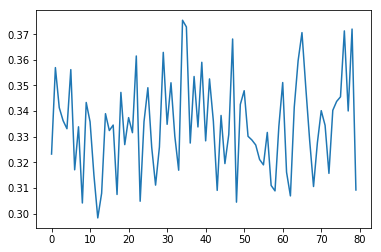

Epoch  16 Summary:  Training_auc : 0.7525886308189812  , Validation_auc :  0.7484349325004936  ,Test_auc :  0.7461393185672438 Test_auc on short visits: 0.726806944679464 Test_auc on long visits: 0.7668718446175908  Avg Loss:  0.33443805704995705 Train Time (2m 18s) Eval Time (1m 21s)


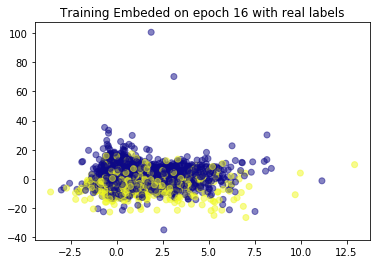

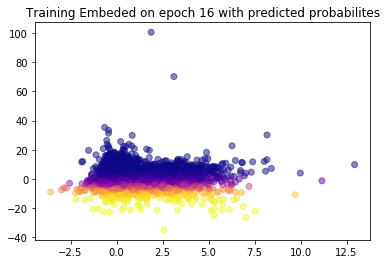


 Current running on: Epoch  17 Training loss:  Average loss 0.33446224106993006


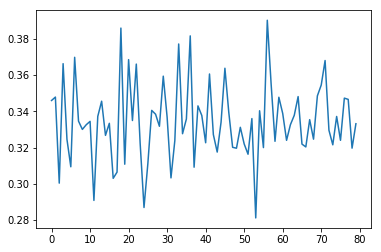

Epoch  17 Summary:  Training_auc : 0.7592103536243994  , Validation_auc :  0.7557365134653262  ,Test_auc :  0.7512426483808217 Test_auc on short visits: 0.7279557030214127 Test_auc on long visits: 0.7754721381269315  Avg Loss:  0.33446224106993006 Train Time (2m 5s) Eval Time (1m 24s)


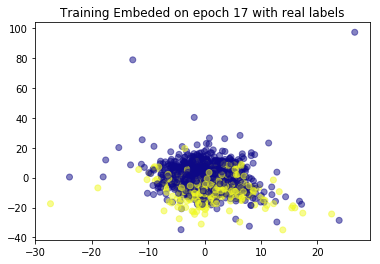

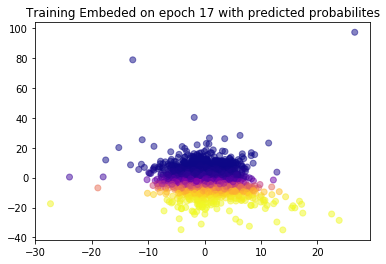


 Current running on: Epoch  18 Training loss:  Average loss 0.3352680867782305


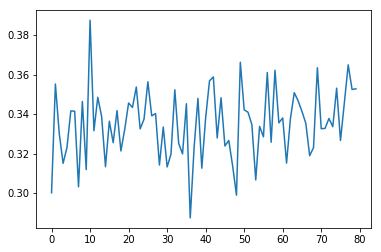

Epoch  18 Summary:  Training_auc : 0.7545522723894207  , Validation_auc :  0.7475029780766508  ,Test_auc :  0.7498967320312446 Test_auc on short visits: 0.7235201873354372 Test_auc on long visits: 0.7750696462513907  Avg Loss:  0.3352680867782305 Train Time (2m 10s) Eval Time (1m 23s)


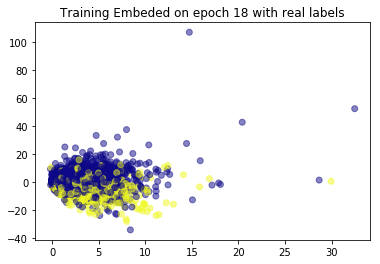

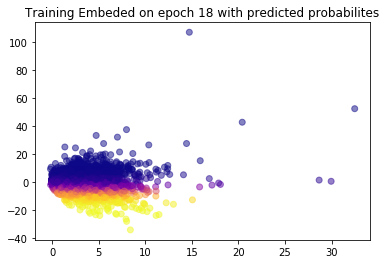


 Current running on: Epoch  19 Training loss:  Average loss 0.33464268255209956


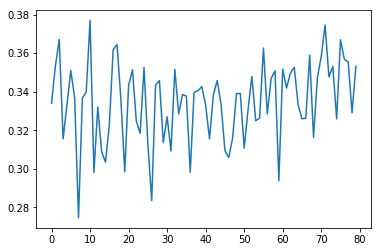

Epoch  19 Summary:  Training_auc : 0.7590500596291324  , Validation_auc :  0.7508592401645053  ,Test_auc :  0.7509279668323272 Test_auc on short visits: 0.7247488270357162 Test_auc on long visits: 0.777007251366197  Avg Loss:  0.33464268255209956 Train Time (2m 7s) Eval Time (1m 22s)


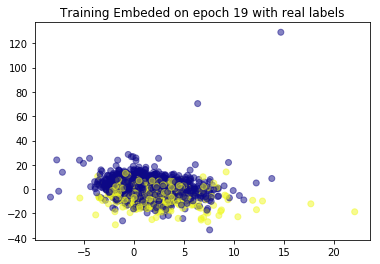

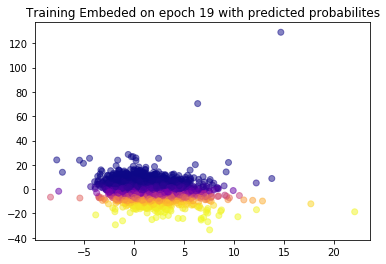

In [11]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, em = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
  
    color1 = np.array([item for item in y_real])
    plt.figure()
    plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    plt.show()
    color2 = np.array([item for item in y_hat])
    plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    plt.show()

In [12]:
# average losses, training auc, validation auc and test auc with epochs
"""
TVT.showPlot(avg_losses_allep)
TVT.showPlot(train_auc_allep)
TVT.showPlot(valid_auc_allep)
TVT.showPlot(test_auc_allep)
"""

'\nTVT.showPlot(avg_losses_allep)\nTVT.showPlot(train_auc_allep)\nTVT.showPlot(valid_auc_allep)\nTVT.showPlot(test_auc_allep)\n'

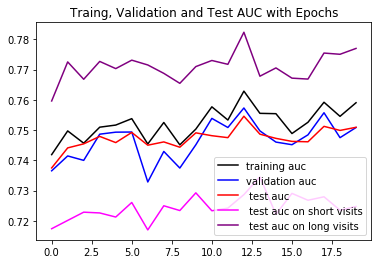

In [13]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [14]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_LargeData_ExcLast_Dim2')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')

In [15]:
#this block is to explore the embedding matrix vs. types. labels
emb_types = pickle.load(open('Data/h143.types', 'rb'),encoding='bytes')
print(type(emb_types)) #dictionary 
print(len(emb_types)) # it is 20000

<class 'dict'>
15815
